# IMDB dataset

The data was downloaded from here: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews. 

The dataset contains 50000 thousand movie reviews, 25 thousand labeled as positive reviews and 25 thousand negative reviews. 

In [1]:
import pandas as pd 
import os

d = pd.read_csv(f'{os.getcwd()}/NLP/movie-reviews/IMDB Dataset.csv')

d.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
d.groupby('sentiment').size()

sentiment
negative    25000
positive    25000
dtype: int64

The classes are distributed uniformaly.

Let us split the data into a train and test sets.

In [3]:
import numpy as np

train = d.sample(frac=0.85)
test = d.drop(train.index)

# Creating the X and Y matrices 
X_train = train['review'].tolist()
Y_train = train['sentiment'].tolist()

X_test = test['review'].tolist()
Y_test = test['sentiment'].tolist()

# Converting to numeric
Y_train = np.array([1 if x=='positive' else 0 for x in Y_train])
Y_test = np.array([1 if x=='positive' else 0 for x in Y_test])

# Text preprocesing 

I will use the same text preprocesing pipeline as in the previous chapter.

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def remove_stop_words(string: str, stop_words=[]) -> str:
    """
    Removes stop words from a string
    """
    string = ' '.join([word for word in string.split() if word not in stop_words])
    
    return string

def preproces_text(strings: list, tokenizer=None, maxlen=None, num_words=None):
    """
    A text preprocesing pipeline
    """
    
    if tokenizer is None:
        # Initating the tokenizer
        tokenizer = Tokenizer(oov_token='<OOV>', num_words=num_words)

    # Fitting on our texts
    tokenizer.fit_on_texts(strings)

    # Text to sequences
    sequences = tokenizer.texts_to_sequences(strings)

    # Padding
    matrix = pad_sequences(sequences, padding='post', maxlen=maxlen)
    
    return matrix, tokenizer

In [5]:
# Reading the stop words
stop_words = pd.read_csv(f'{os.getcwd()}/NLP/stop_words.txt', sep='\n', header=None)[0].tolist()

# Top n words from the corpus based on frequency
num_words = 12000

# Maximum padding 
maxlen = 160

# Removing stop words
X_train = [remove_stop_words(x, stop_words=stop_words) for x in X_train]

# Creating the X train matrix and tokenizer object
X_train, tokenizer = preproces_text(
    X_train, 
    num_words=num_words, 
    maxlen=maxlen
)

# Creating the test matrix
X_test, _ = preproces_text(X_test, tokenizer=tokenizer, maxlen=X_train.shape[1])

In [6]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')

Shape of training data: (42500, 160)
Shape of test data: (7500, 160)


# Creating the word embedding matrix

There are awesome pretrained word embeddings located here: https://nlp.stanford.edu/projects/glove/. We will create an embedding matrix using this information.

In [7]:
def get_coefs(word, *arr): 
    """
    Get coefficient from an embedding file
    """
    return word, np.asarray(arr, dtype='float32')

def get_embedding_index(path):
    """
    Creating the dictionary from the embedding file
    """
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(path, errors='ignore'))
    return embeddings_index

# Creating the word embeddings. I am using the word embeddings saved on my machine 
path = f'{os.getcwd()}/../../embeddings/glove.840B.300d.txt'

# Creating the embeding index
embed_index = get_embedding_index(path=path)

In [8]:
# Getting the word index from the tokenizer
word_index = tokenizer.word_index

# Matrix creation
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for index, word in enumerate(word_index.keys()):
    if index > len(word_index):
        break
    else:
        try:
            embedding_matrix[index] = embed_index[word]
        except:
            continue

# Defining the model

In [9]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         37037400  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 37,269,721
Trainable params: 232,321
Non-trainable params: 37,037,400
______________________________________

In [11]:
num_epochs = 10
history = model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_test, Y_test))

Train on 42500 samples, validate on 7500 samples
Epoch 1/10
42500/42500 [==============================] - 750s 18ms/sample - loss: 0.6069 - accuracy: 0.6649 - val_loss: 0.8029 - val_accuracy: 0.5264
Epoch 2/10
42500/42500 [==============================] - 613s 14ms/sample - loss: 0.4261 - accuracy: 0.8060 - val_loss: 1.2379 - val_accuracy: 0.5199
Epoch 3/10
42500/42500 [==============================] - 574s 14ms/sample - loss: 0.3289 - accuracy: 0.8590 - val_loss: 1.0311 - val_accuracy: 0.5200
Epoch 4/10
42500/42500 [==============================] - 591s 14ms/sample - loss: 0.2715 - accuracy: 0.8873 - val_loss: 1.1927 - val_accuracy: 0.5177
Epoch 5/10
42500/42500 [==============================] - 796s 19ms/sample - loss: 0.2282 - accuracy: 0.9085 - val_loss: 1.1713 - val_accuracy: 0.5137
Epoch 6/10
42500/42500 [==============================] - 623s 15ms/sample - loss: 0.1828 - accuracy: 0.9279 - val_loss: 1.4608 - val_accuracy: 0.5063
Epoch 7/10
42500/42500 [=====================

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

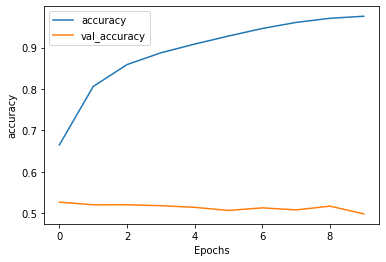

In [13]:
plot_graphs(history, 'accuracy')

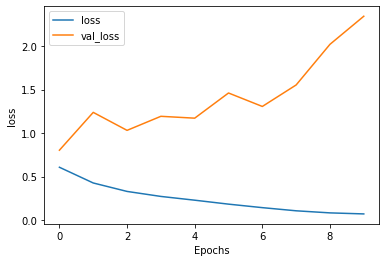

In [14]:
plot_graphs(history, 'loss')

The validation set is not that great but it can be improved by using bigger **maxlen** values, **num_words**, using other custom word embeddings. 

Feel free to experiment with those values yourself.